In [1]:
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tf.random.set_seed(2016)

print("Running Tensorflow version", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Running Tensorflow version 2.19.0
Found GPU at: /device:GPU:0


In [2]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",

    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")
print(f"Dtype of training samles: {train_ds.element_spec[0]}")
print(f"Dtype of training labels: {train_ds.element_spec[1]}")

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326
Dtype of training samles: TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None)
Dtype of training labels: TensorSpec(shape=(), dtype=tf.int64, name=None)


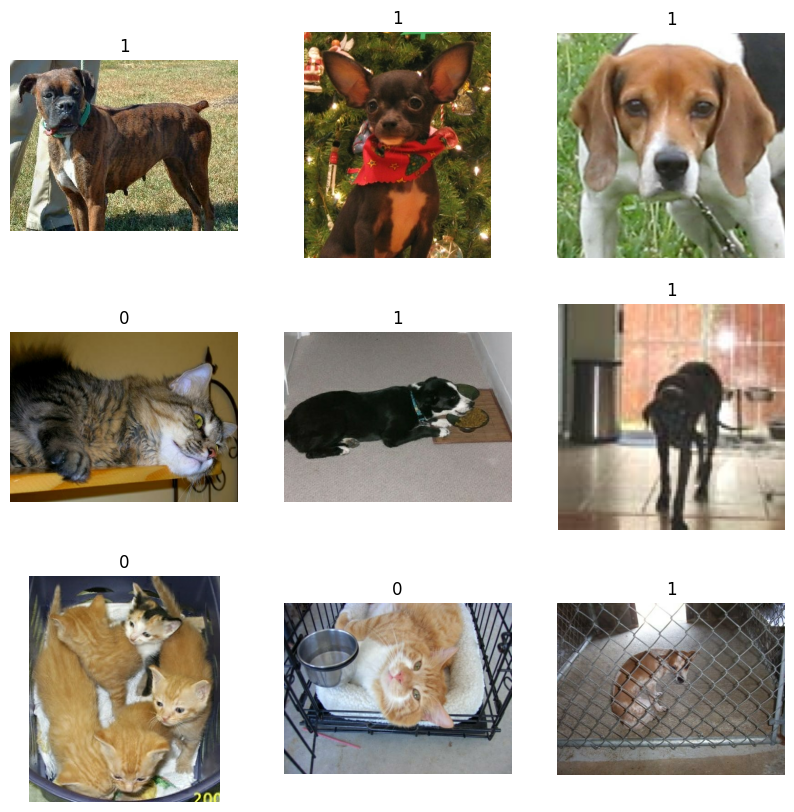

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
resize_fn = keras.layers.Resizing(150, 150, dtype=tf.uint8)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [5]:
print(f"Training set {train_ds.element_spec[0]}")

Training set TensorSpec(shape=(150, 150, 3), dtype=tf.uint8, name=None)


In [6]:

train_ds = train_ds.cache()

augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [7]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [8]:
print(f"Number of training batches: {train_ds.cardinality()}")
print(f"Number of validation batches: {validation_ds.cardinality()}")
print(f"Number of test batches: {test_ds.cardinality()}")

Number of training batches: 146
Number of validation batches: 37
Number of test batches: 37


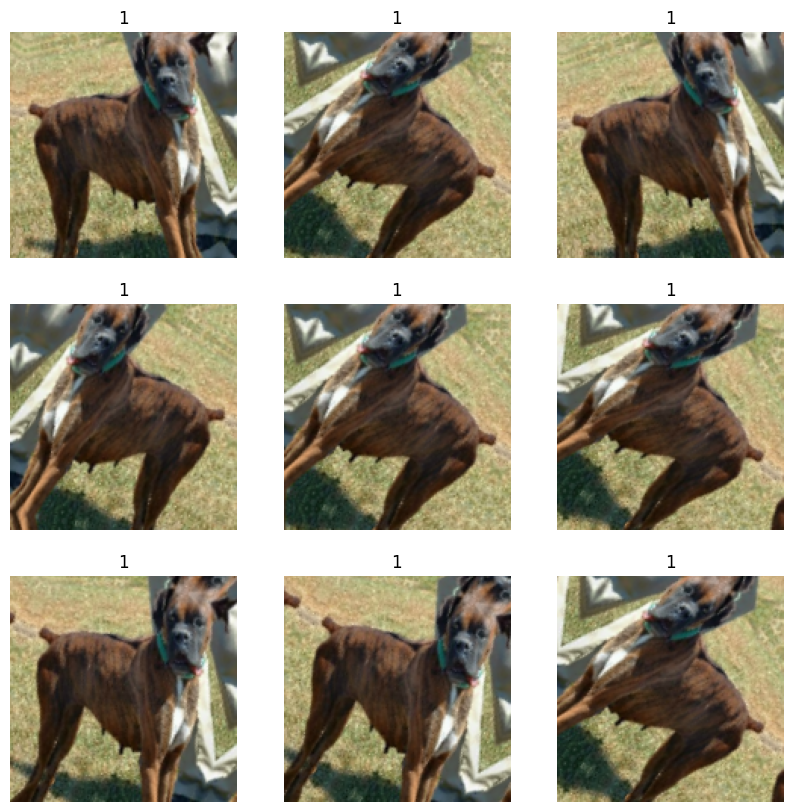

In [9]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [10]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3), include_top=False, weights="imagenet"
)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3), dtype=tf.uint8, name="catdog_input")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

x = preprocess_input(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

/tmp/ipython-input-1982760618.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ catdog_input (InputLayer)   │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 5, 5, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      1,281 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

In [12]:
initial_epochs = 10

print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 88s 480ms/step - accuracy: 0.8207 - loss: 0.3719 - val_accuracy: 0.9643 - val_loss: 0.0897
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 233ms/step - accuracy: 0.9409 - loss: 0.1373 - val_accuracy: 0.9699 - val_loss: 0.0839
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9514 - loss: 0.1237 - val_accuracy: 0.9721 - val_loss: 0.0774
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.9482 - loss: 0.1232 - val_accuracy: 0.9733 - val_loss: 0.0717
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 235ms/step - accuracy: 0.9554 - loss: 0.1090 - val_accuracy: 0.9742 - val_loss: 0.0691
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.9552 - loss: 0.1135 - val_accuracy: 0.9764 - val_loss: 0.0661
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.9595 - loss: 0.1012 - val_accuracy: 0.9751 - val_loss: 0.0722
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 234m

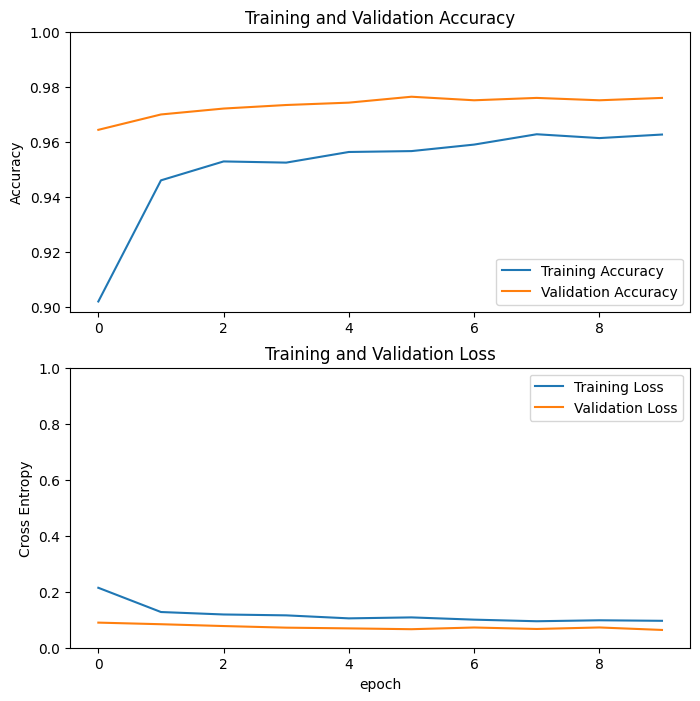

In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [14]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

fine_epochs = 5
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=fine_epochs, validation_data=validation_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ catdog_input (InputLayer)   │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 5, 5, 1280)    │  2,257,984 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      1,281 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 2,564 (10.02 KB)

Fitting the end-to-end model
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 132s 554ms/step - accuracy: 0.8682 - loss: 0.3354 - val_accuracy: 0.9617 - val_loss: 0.1154
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 76s 292ms/step - accuracy: 0.9349 - loss: 0.1611 - val_accuracy: 0.9652 - val_loss: 0.1057
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.9467 - loss: 0.1357 - val_accuracy: 0.9686 - val_loss: 0.0888
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - accuracy: 0.9545 - loss: 0.1130 - val_accuracy: 0.9725 - val_loss: 0.0785
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.9591 - loss: 0.1020 - val_accuracy: 0.9746 - val_loss: 0.0693


In [15]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

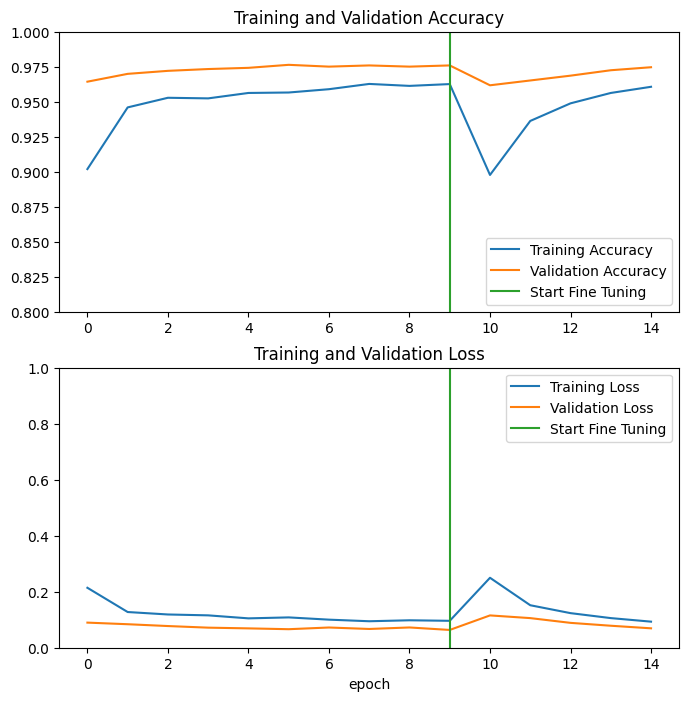

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}".format(test_accuracy))

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9722 - loss: 0.0817
Test loss: 0.09
Test accuracy: 0.97


Predictions:
 [0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1]
Labels:
 [0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1]


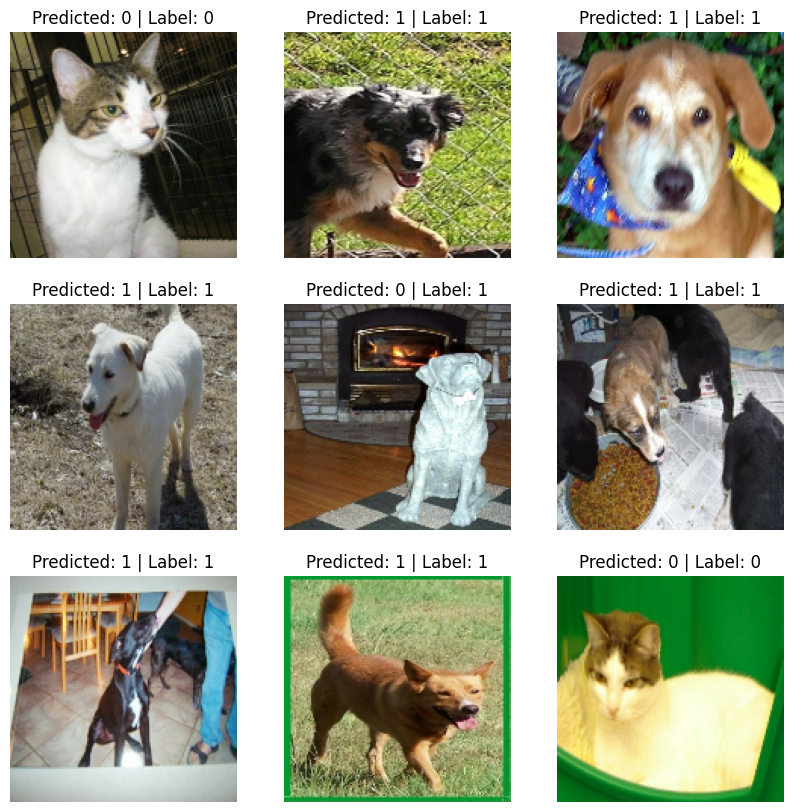

In [18]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Predicted: {} | Label: {}".format(predictions[i], label_batch[i]))
    plt.axis("off")

In [19]:
model_name = "cat-dog-mnv2.keras"
model.save(model_name)